# Estudio del subárbol Phenotypic abnormality en HPO

## 1. Profundidad
Resumen:  
Tamaño: 90978 fenotipos, Profundidad máxima: 14, Media: 5.97.
Plot de dispersión abajo.  
csv en [./results](./results)

In [1]:
# Import global variables from project_config.py

import os
import sys
from IPython.core.getipython import get_ipython

# Absolute path of the current notebook
notebook_path = os.path.realpath(os.path.join(os.getcwd(), get_ipython().starting_dir))
# Add module to system path
config_path = os.path.join(os.path.dirname(notebook_path), "project_config")
sys.path.append(config_path)

import project_config
from project_config import *

print(f"SEED={SEED}")

SEED=42


In [2]:
# Pasos:
# 1. Cargar la ontología HPO
# 2. Obtener subárbol Phenotypic abnormality
# 3. Obtener tamaño N
# 4. Obtener conteo de las profundidades de los nodos del subárbol
# 5. Para cada T = 10%N, 20%N, ..., 100%N:
# a. Obtener la profundidad media de los T primeros nodos del subárbol
# 6. Plot de dispersión de la profundidad media vs. T
import numpy as np
import pandas as pd
from pyhpo import Ontology

PATH_ONTO = "../pubmed-queries/hpo-22-12-15-data"

onto = Ontology(PATH_ONTO)
rDir = 'results'

# 2. Phenotypic abnormality childs
pha = onto.get_hpo_object('HP:0000118')

# 3 & 4

N = 0
h = 0
MAXDEPTH = 14

# Array de profundidades: de 0 a MAX_DEPTH

from queue import Queue

contProfundidades = np.array([0]*(MAXDEPTH+1))
contHojas = np.array([0]*(MAXDEPTH+1))
sAux = Queue()
sAux.put([pha,0])
visitados = {}
phenAttributes = ['id', 'name', 'depth', 'isLeaf']
phenValues = []
while not sAux.empty():
    nodo = sAux.get()
    p = nodo[0]
    if p in visitados.keys():
        visitados[p] = visitados[p] + 1
        continue
    d = nodo[1]
    N = N + 1
    contProfundidades[d] = contProfundidades[d] + 1
    if d > h:
        h = d
    isLeaf = True
    if p.children:
        for c in p.children:
            sAux.put([c,d+1])
        isLeaf = False 
    else:
        contHojas[d] = contHojas[d] + 1
    visitados[p] = 1
    phenValues.append([p.id, p.name, d, isLeaf])

# Save map as pd

df = pd.DataFrame.from_dict(visitados, orient='index')
df.to_csv(rDir + '/visitados.csv')

print("N = ", N)
print("Max depth = ", h)
dfPhen = pd.DataFrame(phenValues, columns=phenAttributes, index=None)
dfPhen.to_csv(rDir + '/phenotypic_abnormality.csv')

N =  16537
Max depth =  14


Depths: [   1   23  155  800 2157 3789 3696 2886 1870  678  334  106   27   13
    2]
[    0     1    24   179   979  3136  6925 10621 13507 15377 16055 16389
 16495 16522 16535 16537]
Leafs: [   0    0   28  318 1198 2502 2569 1985 1535  543  277   95   20   12
    2]
[    0     0     0    28   346  1544  4046  6615  8600 10135 10678 10955
 11050 11070 11082 11084]


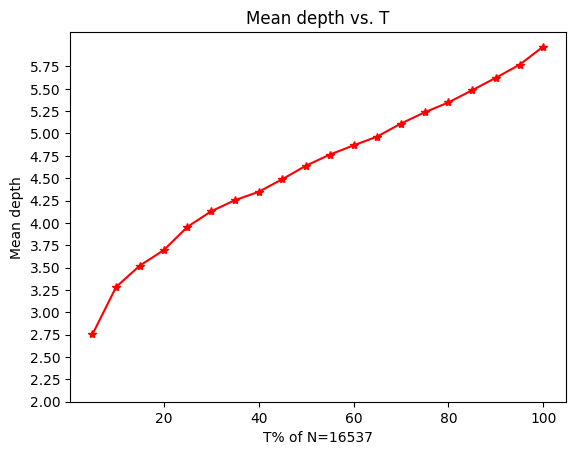

In [3]:
# 5. Para cada T = 10%N, 20%N, ..., 100%N:
# a. Obtener la profundidad media de los T primeros nodos del subárbol

# Array sumas acumuladas de contProfundidades

accumDepth = np.array([0]*(MAXDEPTH+2))
accumHojas = np.array([0]*(MAXDEPTH+2))
for i in range(1,MAXDEPTH+2):
    accumDepth[i] = accumDepth[i-1] + contProfundidades[i-1]
    accumHojas[i] = accumHojas[i-1] + contHojas[i-1]

print("Depths:", contProfundidades)
print(accumDepth)

print("Leafs:", contHojas)
print(accumHojas)

step = 5
nsteps = 100//step
meanDepth = [0] * nsteps

for j in range(0, nsteps):
    sum = 0
    T = (j+1)*step/100
    acum = 0
    i = 0
    k = 0
    while acum < T*N:
        if acum + contProfundidades[i] > T*N:
            k = T*N - acum
            sum = sum + k*i
            acum = T*N
        else:
            sum = sum + contProfundidades[i]*i
            acum = acum + contProfundidades[i]
        i = i + 1
        
    #print("T = ", T, " profundidad media total = ", sum/(T*N))
    meanDepth[j] = sum/(T*N)

# 6. Plot de dispersión de la profundidad media vs. T

import matplotlib.pyplot as plt
import numpy as np

T = np.arange(step,100+step,step)
plt.plot(T, meanDepth, 'r')
plt.plot(T, meanDepth, 'r*')
plt.xlabel(f'T% of N={N}')
plt.ylabel('Mean depth')
plt.yticks(np.arange(int(meanDepth[0]), int(meanDepth[-1])+1, 0.25))
plt.title('Mean depth vs. T')
plt.show()

# Save mean depth
df = pd.DataFrame({'T': T, 'Mean depth': meanDepth})
df.to_csv(rDir + '/mean_depth.csv', index=False)


## 2. Selección de nodos
Vamos a contar cuántos nodos son escogidos a cada profundidad. Se escogen los nodos hoja del árbol cortado a profundidad $d$.

Para cada profundidad $d$ se toman todos los nodos hoja del subárbol que tiene todos los nodos de profundidad $\le d.$ Esto "cubre" intuitivamente el 100% de la ontología. Todo nodo a profundidad mayor que $d$ tiene un único ascendiente en el conjunto de nodos escogidos.

[1, 23, 155, 828, 2503, 5333, 7742, 9501, 10470, 10813, 11012, 11061, 11077, 11083, 11084]


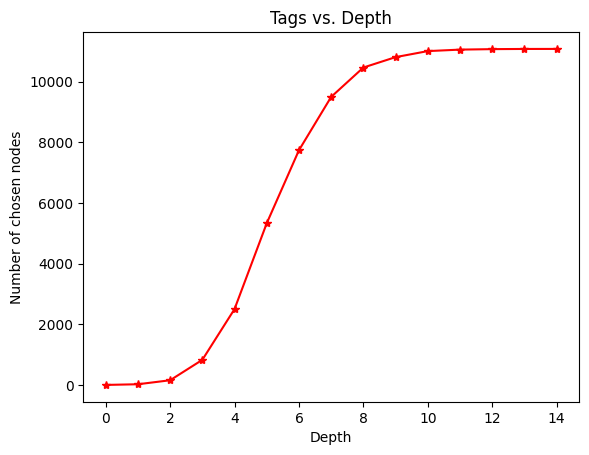

In [4]:
# 7. Plot Nº nodos escogidos vs Profundidad d

# chosen nodes = nodos hoja del subárbol con profundidad d
y = [0]*(MAXDEPTH+1)
z = [0]*(MAXDEPTH+1)
for i in range(MAXDEPTH+1):
    y[i] = contProfundidades[i] + accumHojas[i]

print(y)

plt.plot(range(MAXDEPTH+1), y, 'r')
plt.plot(range(MAXDEPTH+1), y, 'r*')

plt.xlabel('Depth')
plt.ylabel('Number of chosen nodes')
plt.title('Tags vs. Depth')
plt.show()


* Tabla chosen nodes vs depth: subtreePercent es el porcentaje de nodos a profundidad <= d

In [5]:
# Save depth count
dfDepth = pd.DataFrame({'depth': range(MAXDEPTH+1), 'count': contProfundidades, 'leafs': contHojas, 'subtree':accumDepth[1:],'chosen': y})
dfDepth['out'] = N - dfDepth['subtree']
dfDepth['subtreePercent'] = dfDepth['subtree']/N * 100
dfDepth.to_csv(rDir + '/depth_count.csv', index=False, sep='\t')
display(dfDepth)

,depth,count,leafs,subtree,chosen,out,subtreePercent
0,0,1,0,1,1,16536,0.006047
1,1,23,0,24,23,16513,0.145129
2,2,155,28,179,155,16358,1.082421
3,3,800,318,979,828,15558,5.920058
4,4,2157,1198,3136,2503,13401,18.963536
5,5,3789,2502,6925,5333,9612,41.875794
6,6,3696,2569,10621,7742,5916,64.225676
7,7,2886,1985,13507,9501,3030,81.677451
8,8,1870,1535,15377,10470,1160,92.985427
9,9,678,543,16055,10813,482,97.085324


Si quisiéramos no coger todos los nodos del corte a profundidad $d$ sino una muestra no estaríamos cubriendo el 100% de la ontología. ¿Cuánto estaríamos cubriendo? Pues depende de cómo midas el "tamaño" de cada nodo en la ontología. ¿Tienen todos los nodos el mismo tamaño? Entonces solo importaría el número de descendientes de los nodos que se dejan fuera de la muestra. Creo que convendría más medirlo por el IC, pero es complicar la cosa. ¿Cómo se calcula el IC de un conjunto de nodos? Si lo supiera pondría:
$$ \%cubierto = \frac{IC(muestra)} {IC(elegidos)} $$
Una alternativa sería considerando que los nodos más importantes son los que más nodos tienen por debajo:
$$ \%cubierto = \frac{Tam(muestra)} {Tam(elegidos)}$$
donde $Tam(N)$ se refiere al tamaño del subárbol del nodo $N$.

Text(0, 0.5, '% Cubierto')

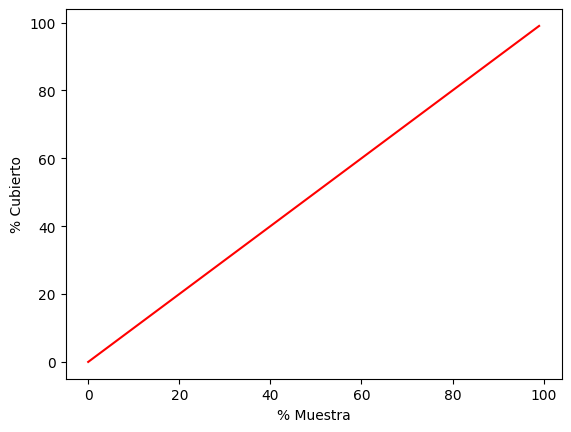

In [6]:
plt.plot(range(100),range(100),'r')
plt.xlabel('% Muestra')
plt.ylabel('% Cubierto')

## Estudiando el IC
IC es una medida de la información del fenotipo y la vamos a utilizar para determinar a priori qué profundidad es la mejor candidata para realizar la muestra. Nos quedaremos con la mayor profundidad $d$ que reporte un IC medio razonable de las etiquetas elegidas por el método anterior (cortar el "árbol" hasta $d$).

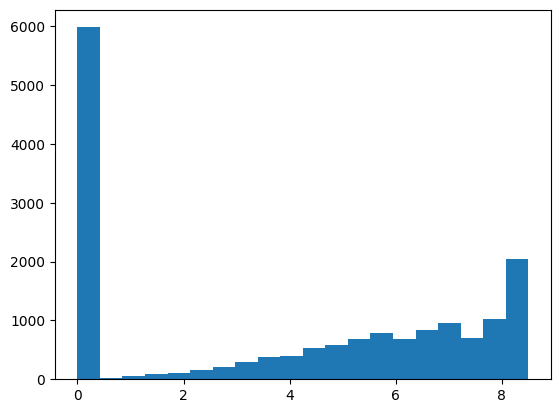

In [7]:
def get_ic(x):
    p = onto.get_hpo_object(x)
    ic = p.information_content.gene
    return ic

dfPhen['ic'] = dfPhen['id'].apply(lambda x: get_ic(x))
plt.hist(dfPhen['ic'], bins=20)
dfPhen.to_csv(rDir + '/phenotypic_abnormality.csv', index=False)

In [8]:
def get_dist(dfPhen, depth):
    dMean = dfPhen[dfPhen['depth'] == depth]['ic'].mean()
    dVar = dfPhen[dfPhen['depth'] == depth]['ic'].var()
    count = int(dfPhen[dfPhen['depth'] == depth]['ic'].count())
    print(f"Depth {depth}: n={count}, mu={dMean}, s^2={dVar}")
    plt.hist(dfPhen[dfPhen['depth'] == depth]['ic'])
    plt.xlabel('IC')
    plt.ylabel('Count')
    plt.title(f'IC histogram for depth={depth}')
    plt.savefig(f"{rDir}/images/ic_depth_{depth}.png")
    plt.clf()
    return dMean, dVar

def get_dist_zeros(dfPhen, depth):
    count = dfPhen[dfPhen['depth'] == depth]['ic'].count()
    dfZeros = dfPhen[(dfPhen['depth'] == depth) & (dfPhen['ic'] == 0.0)]
    dfNotZeros = dfPhen[(dfPhen['depth'] == depth) & (dfPhen['ic'] != 0.0)]
    zeros = int(dfZeros['ic'].count())
    count = int(count - zeros)
    meanAlt = dfNotZeros['ic'].mean()
    varAlt = dfNotZeros['ic'].var()
    trueCount = dfPhen[(dfPhen['depth'] == depth) & (dfPhen['ic'] > 0.0)]['ic'].count()
    trueCount += dfPhen[(dfPhen['depth'] < depth) & (dfPhen['ic'] > 0.0) & (dfPhen['isLeaf'] == True)]['ic'].count()
    print(f"Depth {depth}: trueCount={trueCount},notzeros={count}, zeros={zeros}, mu={meanAlt}, s^2={varAlt}")
    plt.hist(dfNotZeros['ic'])
    plt.xlabel('IC')
    plt.ylabel('Count')
    plt.title(f'IC>0 histogram for depth={depth}')
    plt.savefig(f"{rDir}/images/ic_depth_{depth}_not_zeros.png")
    plt.clf()
    return int(trueCount), int(zeros), int(count), meanAlt, varAlt

dfDist = dfDepth['depth'].apply(lambda x: get_dist(dfPhen, x)).apply(pd.Series)
dfDist.columns = ['mean', 'var']
dfDepth = pd.concat([dfDepth, dfDist], axis=1)
dfDistZeros = dfDepth['depth'].apply(lambda x: get_dist_zeros(dfPhen, x)).apply(pd.Series)
dfDistZeros.columns = ['trueCount', 'zeros', 'notZeros', 'meanGTZ', 'varGTZ']
dfDepth = pd.concat([dfDepth, dfDistZeros], axis=1)
dfDepth.to_csv(rDir + '/depth_count.csv', index=False, sep='\t')


Depth 0: n=1, mu=0.0008166599065559779, s^2=nan
Depth 1: n=23, mu=1.1775103132641087, s^2=0.9205969125256354
Depth 2: n=155, mu=3.1863596269607615, s^2=5.403676207896742
Depth 3: n=800, mu=4.36846122248521, s^2=8.009591181346682
Depth 4: n=2157, mu=4.306912932888519, s^2=9.162555655916076
Depth 5: n=3789, mu=4.230783558541433, s^2=10.081807727296326
Depth 6: n=3696, mu=4.321173851635077, s^2=11.109246335451811
Depth 7: n=2886, mu=3.9205409761575427, s^2=12.640565962730385
Depth 8: n=1870, mu=2.8902837822997363, s^2=12.384680276045414
Depth 9: n=678, mu=3.42800993916492, s^2=12.455999856243334
Depth 10: n=334, mu=3.2475017385811635, s^2=12.554429215216656
Depth 11: n=106, mu=2.298786171399705, s^2=11.704754510686216
Depth 12: n=27, mu=1.6130966559407964, s^2=9.726571004982695
Depth 13: n=13, mu=0.0, s^2=0.0
Depth 14: n=2, mu=0.0, s^2=0.0
Depth 0: trueCount=1,notzeros=1, zeros=0, mu=0.0008166599065559779, s^2=nan
Depth 1: trueCount=23,notzeros=23, zeros=0, mu=1.1775103132641087, s^2=0.92

<Figure size 640x480 with 0 Axes>

In [9]:
df = dfDepth[(dfDepth['depth'] >= 5)].copy()
df.drop(['subtree', 'leafs', 'chosen', 'out', 'subtreePercent', 'mean', 'var'], axis=1, inplace=True)
display(df)

,depth,count,trueCount,zeros,notZeros,meanGTZ,varGTZ
5,5,3789,3610.0,1158.0,2631.0,6.092907,3.170809
6,6,3696,4942.0,1227.0,2469.0,6.468634,2.735594
7,7,2886,5688.0,1217.0,1669.0,6.779318,2.471154
8,8,1870,5916.0,1077.0,793.0,6.815676,2.437992
9,9,678,6049.0,330.0,348.0,6.678709,2.528724
10,10,334,6107.0,172.0,162.0,6.695467,2.737492
11,11,106,6109.0,72.0,34.0,7.166804,1.297056
12,12,27,6109.0,21.0,6.0,7.258935,1.398842
13,13,13,6106.0,13.0,0.0,NaN,NaN
14,14,2,6106.0,2.0,0.0,NaN,NaN


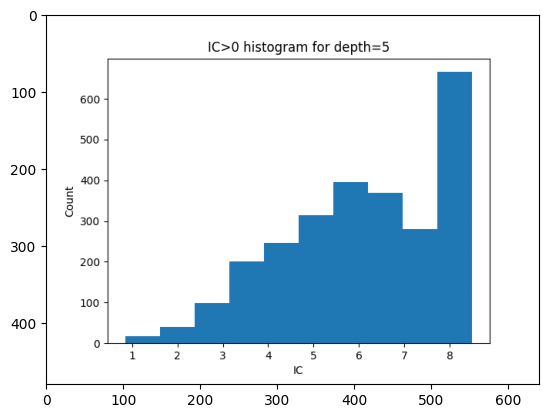

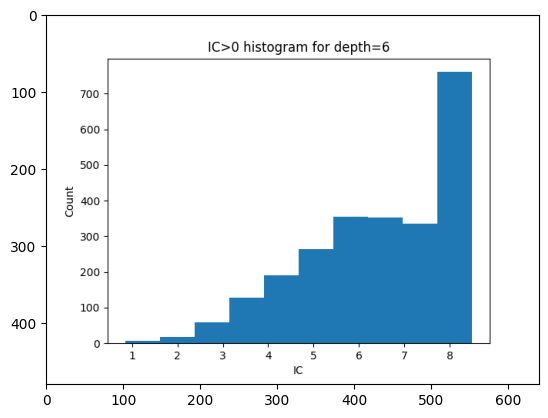

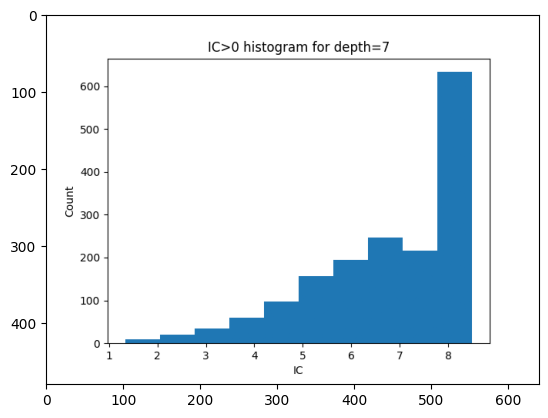

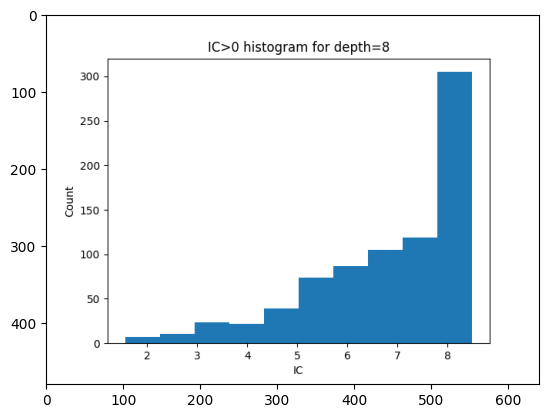

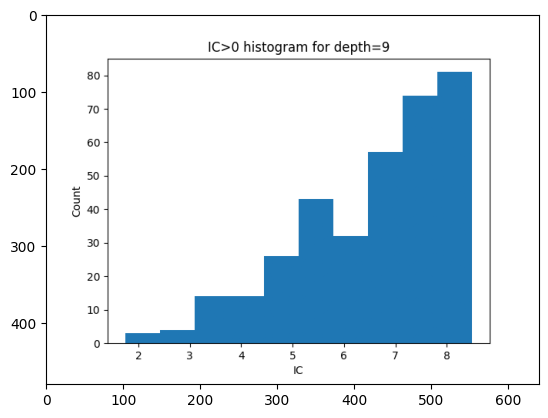

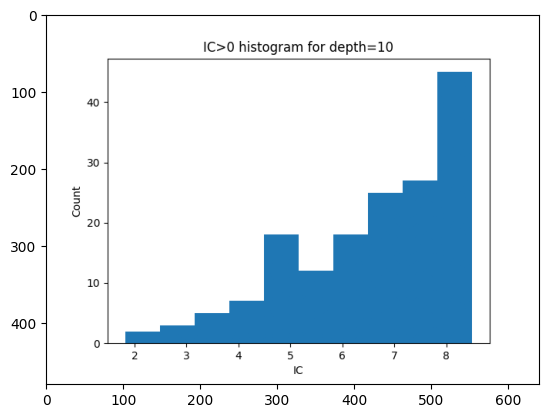

In [10]:
import matplotlib.image as mpimg
for d in range(5,11):
    img = mpimg.imread(f"{rDir}/images/ic_depth_{d}_not_zeros.png")
    plt.imshow(img)
    plt.show()

In [11]:
# Conseguir distribucion real a cada profundidad
def get_true_dist(dfPhen, depth):
    df = dfPhen[dfPhen['ic'] > 0]
    dfLess = df[(df['depth'] < depth) & df['isLeaf']]
    dfEq = df[df['depth'] == depth]
    dfTrue = pd.concat([dfLess, dfEq])
    mean = dfTrue['ic'].mean()
    var = dfTrue['ic'].var()
    count = dfTrue['ic'].count()
    print(f"Depth {depth}: n={count}, mu={mean}, s^2={var}")
    plt.hist(dfTrue['ic'])
    plt.xlabel('IC')
    plt.ylabel('Count')
    plt.title(f'IC>0 histogram for true depth selection={depth}')
    plt.savefig(f"{rDir}/images/ic_depth_{depth}_true.png")
    plt.clf()
    return mean, var

dfTrueDist = dfDepth['depth'].apply(lambda x: get_true_dist(dfPhen, x)).apply(pd.Series)
dfTrueDist.columns = ['trueMean', 'trueVar']
dfDepth = pd.concat([dfDepth, dfTrueDist], axis=1)

dfDepth.to_csv(rDir + '/depth_count.csv', index=False, sep='\t')

Depth 0: n=1, mu=0.0008166599065559779, s^2=nan
Depth 1: n=23, mu=1.1775103132641087, s^2=0.9205969125256352
Depth 2: n=138, mu=3.5788821897023047, s^2=4.659159407259273
Depth 3: n=680, mu=5.30814491869392, s^2=4.819274401025178
Depth 4: n=1846, mu=5.87612360490593, s^2=3.9573354423686347
Depth 5: n=3610, mu=6.336812125750459, s^2=2.9972694499750867
Depth 6: n=4942, mu=6.688773191729375, s^2=2.3877200420611584
Depth 7: n=5688, mu=6.905435594016414, s^2=2.0559295251989695
Depth 8: n=5916, mu=6.978093466598968, s^2=1.9207818245278965
Depth 9: n=6049, mu=7.003977108613174, s^2=1.859948987140244
Depth 10: n=6107, mu=7.0214524048613844, s^2=1.8362413373679678
Depth 11: n=6109, mu=7.028558777630759, s^2=1.8252225731163003
Depth 12: n=6109, mu=7.02965474262108, s^2=1.8245083542015166
Depth 13: n=6106, mu=7.02979052732341, s^2=1.824604795747551
Depth 14: n=6106, mu=7.02979052732341, s^2=1.824604795747551


<Figure size 640x480 with 0 Axes>

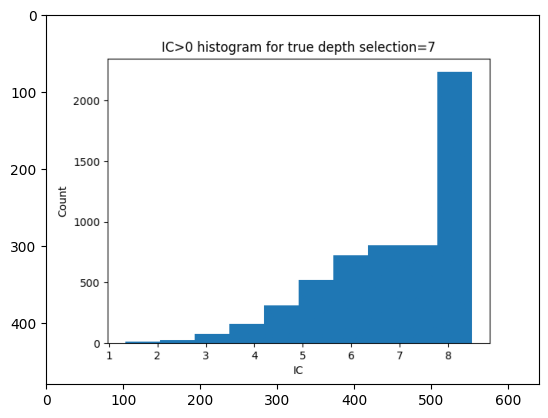

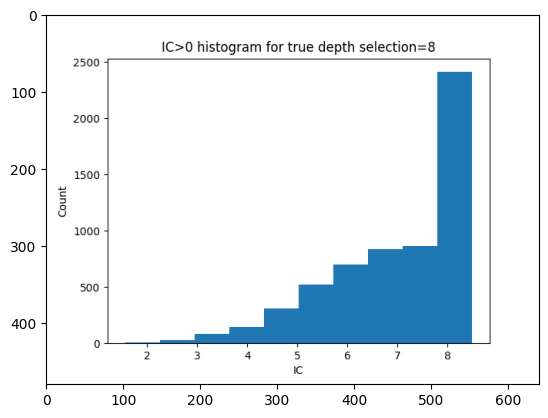

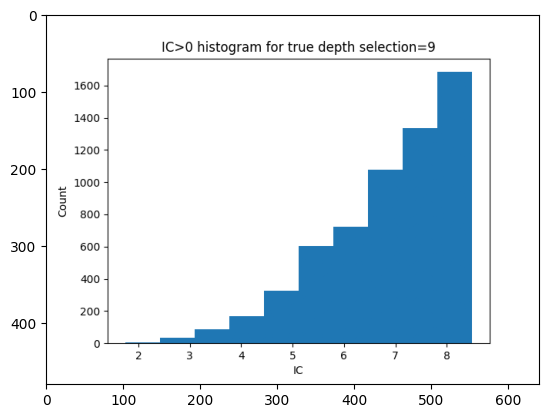

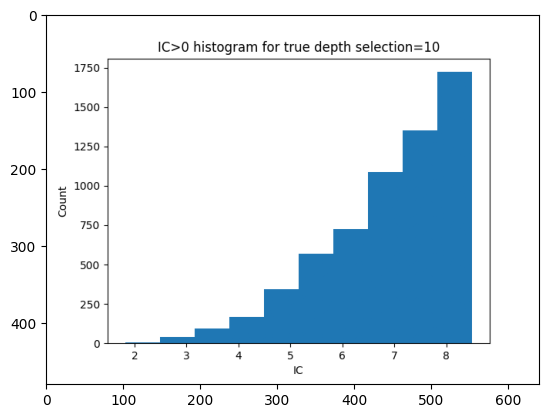

In [12]:
import matplotlib.image as mpimg
for d in range(7,11):
    img = mpimg.imread(f"{rDir}/images/ic_depth_{d}_true.png")
    plt.imshow(img)
    plt.show()

## TODO:
1. Calcular % ontología cubierta por depth=10
2. Hacer un informe sobre el análisis que hemos hecho para la selección de fenotipos:
   1. Método de selección
   2. Por qué usamos el IC
   3. NAs
   4. Resultados
   5. % ontología cubierto por la selección

In [13]:
display(dfDepth)

,depth,count,leafs,subtree,chosen,out,subtreePercent,mean,var,trueCount,zeros,notZeros,meanGTZ,varGTZ,trueMean,trueVar
0,0,1,0,1,1,16536,0.006047,0.000817,NaN,1.0,0.0,1.0,0.000817,NaN,0.000817,NaN
1,1,23,0,24,23,16513,0.145129,1.177510,0.920597,23.0,0.0,23.0,1.177510,0.920597,1.177510,0.920597
2,2,155,28,179,155,16358,1.082421,3.186360,5.403676,138.0,17.0,138.0,3.578882,4.659159,3.578882,4.659159
3,3,800,318,979,828,15558,5.920058,4.368461,8.009591,680.0,138.0,662.0,5.279107,4.867119,5.308145,4.819274
4,4,2157,1198,3136,2503,13401,18.963536,4.306913,9.162556,1846.0,535.0,1622.0,5.727504,4.045136,5.876124,3.957335
5,5,3789,2502,6925,5333,9612,41.875794,4.230784,10.081808,3610.0,1158.0,2631.0,6.092907,3.170809,6.336812,2.997269
6,6,3696,2569,10621,7742,5916,64.225676,4.321174,11.109246,4942.0,1227.0,2469.0,6.468634,2.735594,6.688773,2.387720
7,7,2886,1985,13507,9501,3030,81.677451,3.920541,12.640566,5688.0,1217.0,1669.0,6.779318,2.471154,6.905436,2.055930
8,8,1870,1535,15377,10470,1160,92.985427,2.890284,12.384680,5916.0,1077.0,793.0,6.815676,2.437992,6.978093,1.920782
9,9,678,543,16055,10813,482,97.085324,3.428010,12.456000,6049.0,330.0,348.0,6.678709,2.528724,7.003977,1.859949


In [14]:
# ntrue es trueCount a profundidad MAXDEPTH
ntrue = dfDepth[dfDepth['depth'] == MAXDEPTH]['trueCount'].values[0]
def onto_percent(onto, dfDepth, d, ntrue, tam=0):
    # 1. Eliminar nodos nulos (IC = 0)
    # 2. Seleccionar todos los nodos hoja con profundidad < d
    # 3. Añadir todos los nodos con profundidad = d
    # 4. Calcular número de nodos hoja no nulos cubiertos en la ontología
        # mediante un recorrido en anchura o profundidad
    # 5. Calcular el porcentaje de nodos hoja no nulos cubiertos
    # 6. Return n, porcentaje y dataframe de la seleccion

    # 1.
    df = dfPhen[dfPhen['ic'] > 0]
    # 2.
    dfLess = df[(df['depth'] < d) & df['isLeaf']]
    
    # 3.
    dfEq = df[df['depth'] == d]
    
    dfTrue = pd.concat([dfLess, dfEq])

    m = dfTrue['ic'].count() 
    if tam > 0:
        dfTrue = dfTrue.sample(min(tam,m), random_state=SEED)
    # 4.
    cont = 0
    sAux = Queue()
    for id in dfTrue['id']:
        sAux.put(onto.get_hpo_object(id))
    visitados = set()
    while not sAux.empty():
        p = sAux.get()
        if p in visitados:
            continue
        if p.children:
            for c in p.children:
                sAux.put(c)
        else:
            if p.information_content.gene > 0.0:
                cont += 1
        visitados.add(p)
    # 5.
    return cont, dfTrue

fullCover = {}
for d in range(MAXDEPTH+1):
    n, df = onto_percent(onto, dfDepth, d, ntrue)
    fullCover[d] = n
    print(f"Depth {d}: {n} not-null nodes covered, {n/ntrue*100}%")

dfDepth['fullCover'] = dfDepth['depth'].apply(lambda x: fullCover[x])

Depth 0: 6106 not-null nodes covered, 100.0%
Depth 1: 6106 not-null nodes covered, 100.0%
Depth 2: 6106 not-null nodes covered, 100.0%
Depth 3: 6106 not-null nodes covered, 100.0%
Depth 4: 6106 not-null nodes covered, 100.0%
Depth 5: 6106 not-null nodes covered, 100.0%
Depth 6: 6106 not-null nodes covered, 100.0%
Depth 7: 6106 not-null nodes covered, 100.0%
Depth 8: 6106 not-null nodes covered, 100.0%
Depth 9: 6106 not-null nodes covered, 100.0%
Depth 10: 6106 not-null nodes covered, 100.0%
Depth 11: 6106 not-null nodes covered, 100.0%
Depth 12: 6106 not-null nodes covered, 100.0%
Depth 13: 6106 not-null nodes covered, 100.0%
Depth 14: 6106 not-null nodes covered, 100.0%


In [15]:
trueCover = {}
TAM = 2000

for d in range(MAXDEPTH+1):
    n, df = onto_percent(onto, dfDepth, d, ntrue, tam=TAM)
    trueCover[d] = n
    print(f"Depth {d}, tam={TAM}: {n} nodes covered, {n/ntrue*100}%")

dfDepth['sample'] = dfDepth['trueCount'].apply(lambda x: int(min(x,TAM)))
dfDepth['sampleCover'] = dfDepth['depth'].apply(lambda x: trueCover[x])
dfDepth['sampleCoverPercent'] = dfDepth['sampleCover']/ntrue*100

display(dfDepth)


Depth 0, tam=2000: 6106 nodes covered, 100.0%
Depth 1, tam=2000: 6106 nodes covered, 100.0%
Depth 2, tam=2000: 6106 nodes covered, 100.0%
Depth 3, tam=2000: 6106 nodes covered, 100.0%
Depth 4, tam=2000: 6106 nodes covered, 100.0%
Depth 5, tam=2000: 3831 nodes covered, 62.74156567310841%
Depth 6, tam=2000: 2653 nodes covered, 43.44906649197511%
Depth 7, tam=2000: 2156 nodes covered, 35.309531608254176%
Depth 8, tam=2000: 2152 nodes covered, 35.244022273173925%
Depth 9, tam=2000: 2033 nodes covered, 33.29511955453653%
Depth 10, tam=2000: 2006 nodes covered, 32.85293154274484%
Depth 11, tam=2000: 1998 nodes covered, 32.72191287258434%
Depth 12, tam=2000: 2000 nodes covered, 32.754667540124466%
Depth 13, tam=2000: 2000 nodes covered, 32.754667540124466%
Depth 14, tam=2000: 2000 nodes covered, 32.754667540124466%


,depth,count,leafs,subtree,chosen,out,subtreePercent,mean,var,trueCount,zeros,notZeros,meanGTZ,varGTZ,trueMean,trueVar,fullCover,sample,sampleCover,sampleCoverPercent
0,0,1,0,1,1,16536,0.006047,0.000817,NaN,1.0,0.0,1.0,0.000817,NaN,0.000817,NaN,6106,1,6106,100.000000
1,1,23,0,24,23,16513,0.145129,1.177510,0.920597,23.0,0.0,23.0,1.177510,0.920597,1.177510,0.920597,6106,23,6106,100.000000
2,2,155,28,179,155,16358,1.082421,3.186360,5.403676,138.0,17.0,138.0,3.578882,4.659159,3.578882,4.659159,6106,138,6106,100.000000
3,3,800,318,979,828,15558,5.920058,4.368461,8.009591,680.0,138.0,662.0,5.279107,4.867119,5.308145,4.819274,6106,680,6106,100.000000
4,4,2157,1198,3136,2503,13401,18.963536,4.306913,9.162556,1846.0,535.0,1622.0,5.727504,4.045136,5.876124,3.957335,6106,1846,6106,100.000000
5,5,3789,2502,6925,5333,9612,41.875794,4.230784,10.081808,3610.0,1158.0,2631.0,6.092907,3.170809,6.336812,2.997269,6106,2000,3831,62.741566
6,6,3696,2569,10621,7742,5916,64.225676,4.321174,11.109246,4942.0,1227.0,2469.0,6.468634,2.735594,6.688773,2.387720,6106,2000,2653,43.449066
7,7,2886,1985,13507,9501,3030,81.677451,3.920541,12.640566,5688.0,1217.0,1669.0,6.779318,2.471154,6.905436,2.055930,6106,2000,2156,35.309532
8,8,1870,1535,15377,10470,1160,92.985427,2.890284,12.384680,5916.0,1077.0,793.0,6.815676,2.437992,6.978093,1.920782,6106,2000,2152,35.244022
9,9,678,543,16055,10813,482,97.085324,3.428010,12.456000,6049.0,330.0,348.0,6.678709,2.528724,7.003977,1.859949,6106,2000,2033,33.295120


Decisión: tomar la selección (sin nulos) a profundidad **10** porque:
* El IC medio de la selección crece con la profundidad, pero se estanca a esa profundidad 10 en las centésimas, aparte de que a partir de esa profundidad se añaden muy pocos nodos no nulos.
* Con una muestra de tamaño 2000 de la selección a profundidad 10 cubrimos un 32.82% de los nodos hoja no nulos de la ontología, que es un porcentaje suficiente.
* Importante considerar que si hacemos la muestra completa de 6106 nodos no nulos cubrimos el 100%.

In [16]:
columns = ['depth', 'trueMean', 'sampleCoverPercent', 'sample']
display(dfDepth[columns])
dfDepth.to_csv('results/depth_count.csv', sep='\t', index=False)


,depth,trueMean,sampleCoverPercent,sample
0,0,0.000817,100.000000,1
1,1,1.177510,100.000000,23
2,2,3.578882,100.000000,138
3,3,5.308145,100.000000,680
4,4,5.876124,100.000000,1846
5,5,6.336812,62.741566,2000
6,6,6.688773,43.449066,2000
7,7,6.905436,35.309532,2000
8,8,6.978093,35.244022,2000
9,9,7.003977,33.295120,2000


Text(0, 0.5, '%')

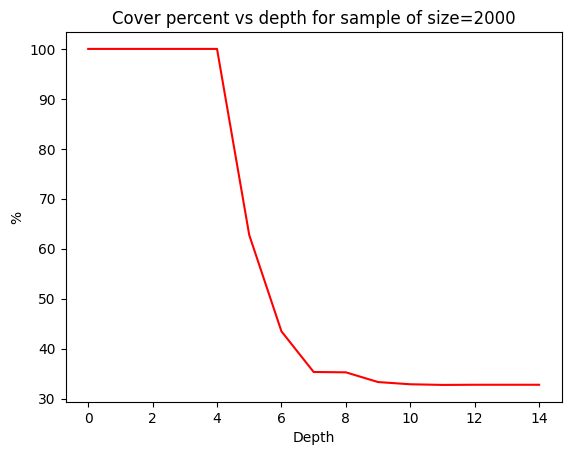

In [17]:
# Plot del sampleCoverPercent vs. depth
plt.plot(dfDepth['depth'], dfDepth['sampleCoverPercent'], 'r')
plt.title('Cover percent vs depth for sample of size=2000')
plt.xlabel('Depth')
plt.ylabel('%')